# Open questions and comments 

(!) V2 is the EDA where I am changing the order to make it fit with the report (Results)

(?) Should data from #GivingTuesday be analyzed separately?

(?) Does it make sense to substitute the number of transactions on #GivingTuesday with the second highest number of transaction during the year? or should we just calculate the avg number of transactions without givingtuesday and use that value? 


## TODOS - if necessary 

* Plots/tables of clients/transactions per channel and hozur (?)/day/week/month 
* Figure out emails or specific campaigns - how are they influencing the results? 
* Impute missing data in empty channels (see youtube ads)
* check ratio unique clients ID / transactions 
    - per day 
    - on giving Tuesday 
    - per channel group 

# Part I. EDA 


## Getting data from Supermetrics

Follow tutorial https://supermetrics.com/blog/how-to-load-data-into-mysql

Urls are stored in 'constants.py', which will not be pushed into the repo. Urls contain the supermetrics queries for different timeframes in 2021. At first, just basic information (client IDs, transaction yes/no + transaction amount) are imported

After some trials with different time frames, I finally decided to work with 12 months (01.01.2021 - 31.12.2021)

Steps to import data from supermetrics: 

* Import urls from constant file
* Call API 
* Check response - response needs to be 200 to be successfull; 500 indicates error

In [2]:
import requests
import urllib.parse as up
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 


*url* contains the basic information about Client ID and transactions 

In order to import other features of interest, two additional URLs were created (one was not enough, because just 9 features are allowed). Those are *url_extended1* and *url_extended2*. I will import them and join them in a complete table. 


In [3]:
import constants_year_MT 
import importlib # to reload the constants module. Necessary if we do changes in module 


# to reload modules that have changed: 
# https://stackoverflow.com/questions/33323707/how-do-i-reload-a-module-after-changing-it 

In [4]:
# import basic table + call API + check response (200 for ok, 500 for error)
# just needed for pre-check of the dataset - information is also contained on the extended table 
# takes 5-10 seconds 
# importlib.reload(constants_year_MT)
# from constants_year_MT import url_12months 
# response_basic = requests.get(url_12months)
# print(response_basic)

In [5]:
# import extended table, part 1 (session info)
# takes 2-3 minutes 
importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_extended_part1
response_extended1 = requests.get(url_12months_extended_part1)
print(response_extended1)

<Response [200]>


In [6]:
# import extended table, part 2 (demographic info)
# takes 2-3 minutes
importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_extended_part2
response_extended2 = requests.get(url_12months_extended_part2)
print(response_extended2)

<Response [200]>


### Create table from url data 

* Define function 
* Apply to different URLs
* Merge tables of extended datasets 
* Check available features

In [7]:
# function to create dataframe from url data 
def url_to_df (url, response): 
    """
    Function to create pandas dataframe from url data. Imported data needs 
    to be of type json or keyjson. Otherwise an exception error is thrown

    Arguments: 
        url: url previously imported from constants file 
        response: previously extracted response 

    Returns: 
        df2: supermetrics information transformed into pandas dataframe 
    """

    if 'data/json?' in url:
        # convert json into pandas df 
        data = json.loads(json.dumps(response.json()))
        df = pd.DataFrame.from_dict(data['data'])
        headers = df.iloc[0]
        df2 = pd.DataFrame(df.values[1:], columns=headers)
    elif 'data/keyjson?' in url:
        # convert json key-value pair output to pandas df 
        df2 = pd.read_json(json.dumps(response.json()))
    else:
        # throw exception message 
        import sys
        sys.exit("DEFINE JSON OR KEYJSON AS OUTPUT FORMAT: https://supermetrics.com/docs/product-api-output-formats/")
    return df2     

In [8]:
# create data frame for complete year 2021 - basic features 
# df_basic = url_to_df(url_12months, response_basic)
# df_basic

Dimension of both tables are different (466.287 df_extended1 vs 421.542 df_extended2 vs 442.104 df_basic). This is caused by combination of different features. An left join (of the biggest table) was then done. 

In [23]:
# create dataframe for year 2021 - extended set of features 
df_extended1 = url_to_df(url_12months_extended_part1, response_extended1)
df_extended2 = url_to_df(url_12months_extended_part2, response_extended2)

# join df_extended1 and df_extended2 using common features (specially clientID & Date)
df_extended = pd.merge(df_extended1, df_extended2, how = 'left', on = ['clientID', 'Date', 'Users', 'Transactions'])

## Data pretreatment

* Transform data into correct format
* Create features: path_order, new_old_client_in_2021

In [10]:
# function to convert data to correct format
def transform_class (df, feats_to_convert):
    for f in feats_to_convert: 
        if f == 'Date':
            df[f] = pd.to_datetime(df[f])
        else: # all numeric 
            df[f] = pd.to_numeric(df[f], errors = 'coerce')
    return df

In [24]:
feats_to_convert_for_extended = ['Date', 'Users', 'Transactions', 'Transaction revenue', 'Pageviews', 'Hits', 'Total time on site', 'Bounces', 'Total events', 'Latitude', 'Longitude']
df_extended = transform_class(df_extended, feats_to_convert_for_extended)

In [25]:
# create path order per clientID 
df_extended['path_order'] = df_extended.sort_values(['Date']).groupby(['clientID']).cumcount() + 1
# create feature of new/old client in 2021
## new => path_order = 1
## old => path_order > 1
df_extended['type_of_client_by_path_order'] = (df_extended.path_order > 1).astype('int')
# change categories 
df_extended.type_of_client_by_path_order[df_extended.type_of_client_by_path_order == 1] = 'old_by_path_order'
df_extended.type_of_client_by_path_order[df_extended.type_of_client_by_path_order == 0] = 'new_by_path_order'

C:\Users\carol\AppData\Local\Temp\ipykernel_12016\1502578285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended.type_of_client_by_path_order[df_extended.type_of_client_by_path_order == 1] = 'old_by_path_order'


In [26]:
# order table by clientID, date and path order 
df_extended = df_extended.sort_values(['clientID', 'Date', 'path_order'])

In [27]:
# create feature of new/old client - grouping information + merge with original dataset 
new_old_client = df_extended[['clientID', 'Date', 'path_order']]
new_old_client = new_old_client.sort_values(['clientID', 'path_order'])
# just keep last one 
new_old_client = new_old_client.drop_duplicates('clientID', keep = 'last')
new_old_client['general_type_of_client'] = (new_old_client.path_order > 1).astype('int')
# change name of categories 
new_old_client.general_type_of_client[new_old_client.general_type_of_client == 1] = 'old_in_2021'
new_old_client.general_type_of_client[new_old_client.general_type_of_client == 0] = 'new_in_2021'

# new_old_client[new_old_client['path_order'] > 1][['path_order', 'general_type_of_client']].value_counts()

C:\Users\carol\AppData\Local\Temp\ipykernel_12016\3850220782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_old_client.general_type_of_client[new_old_client.general_type_of_client == 1] = 'old_in_2021'


In [28]:
# merge with original table using clientID to have new_old_client feature available 
df_extended = pd.merge(df_extended, new_old_client, how = 'left', on = ('clientID'))
# check result 
# df_extended[df_extended['path_order_x'] > 1][['general_type_of_client']].value_counts()
df_extended

,clientID,Date_x,Source,Medium,Channel group,Keyword,User type,Operating system,Users,Transactions,...,Hits,Total time on site,Sessions,Bounces,Total events,path_order_x,type_of_client_by_path_order,Date_y,path_order_y,general_type_of_client
0,1000005671.1568444004,2021-01-04,google,cpc,Display,USDlt15K,Returning Visitor,Android,1,0,...,2.0,0.0,1,1.0,1.0,1,new_by_path_order,2021-01-04,1,new_in_2021
1,1000006728.1622927843,2021-06-05,(direct),(none),Direct,(not set),New Visitor,iOS,1,0,...,1.0,0.0,1,1.0,0.0,1,new_by_path_order,2021-06-05,1,new_in_2021
2,1000020259.1556972396,2021-01-31,trafficbot.life,referral,Referral,(not set),New Visitor,Android,1,0,...,1.0,0.0,1,1.0,0.0,1,new_by_path_order,2021-01-31,1,new_in_2021
3,1000023369.1635190743,2021-10-25,sos-kinderdorf.bewerberportal.at,referral,Referral,(not set),New Visitor,Android,1,0,...,3.0,0.0,1,1.0,2.0,1,new_by_path_order,2021-10-25,1,new_in_2021
4,1000024791.1630470945,2021-09-01,google,cpc,Branded Paid Search,sos kinderdorf,New Visitor,iOS,1,0,...,7.0,40.0,1,0.0,5.0,1,new_by_path_order,2021-09-01,1,new_in_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471527,999973068.1611254848,2021-01-21,google,cpc,Display,(automatic matching),New Visitor,Android,1,0,...,1.0,0.0,1,1.0,0.0,1,new_by_path_order,2021-01-21,1,new_in_2021
471528,99997309.1608586309,2021-01-04,google,cpc,Display,USDlt15K,Returning Visitor,Android,1,0,...,1.0,0.0,1,1.0,0.0,1,new_by_path_order,2021-01-04,1,new_in_2021
471529,999988377.1636720143,2021-11-12,google,cpc,Display,(automatic matching),New Visitor,Windows,1,0,...,1.0,0.0,1,1.0,0.0,1,new_by_path_order,2021-11-12,1,new_in_2021
471530,999996741.1623865085,2021-06-16,facebook,darkpost,(Other),(not set),New Visitor,Android,1,0,...,3.0,0.0,1,1.0,2.0,1,new_by_path_order,2021-06-16,1,new_in_2021


In [29]:
# change name of columns 
df_extended.rename(columns = {'Date_x':'Date', 'path_order_x':'path_order'}, inplace = True)

In [30]:
# drop redundant columns 
df_extended.drop('Date_y', axis = 1, inplace = True)
df_extended.drop('path_order_y', axis = 1, inplace = True)

In [31]:
# check final dataset to work with 
df_extended

,clientID,Date,Source,Medium,Channel group,Keyword,User type,Operating system,Users,Transactions,...,Transaction revenue,Pageviews,Hits,Total time on site,Sessions,Bounces,Total events,path_order,type_of_client_by_path_order,general_type_of_client
0,1000005671.1568444004,2021-01-04,google,cpc,Display,USDlt15K,Returning Visitor,Android,1,0,...,0.0,1.0,2.0,0.0,1,1.0,1.0,1,new_by_path_order,new_in_2021
1,1000006728.1622927843,2021-06-05,(direct),(none),Direct,(not set),New Visitor,iOS,1,0,...,0.0,1.0,1.0,0.0,1,1.0,0.0,1,new_by_path_order,new_in_2021
2,1000020259.1556972396,2021-01-31,trafficbot.life,referral,Referral,(not set),New Visitor,Android,1,0,...,0.0,1.0,1.0,0.0,1,1.0,0.0,1,new_by_path_order,new_in_2021
3,1000023369.1635190743,2021-10-25,sos-kinderdorf.bewerberportal.at,referral,Referral,(not set),New Visitor,Android,1,0,...,0.0,1.0,3.0,0.0,1,1.0,2.0,1,new_by_path_order,new_in_2021
4,1000024791.1630470945,2021-09-01,google,cpc,Branded Paid Search,sos kinderdorf,New Visitor,iOS,1,0,...,0.0,2.0,7.0,40.0,1,0.0,5.0,1,new_by_path_order,new_in_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471527,999973068.1611254848,2021-01-21,google,cpc,Display,(automatic matching),New Visitor,Android,1,0,...,0.0,1.0,1.0,0.0,1,1.0,0.0,1,new_by_path_order,new_in_2021
471528,99997309.1608586309,2021-01-04,google,cpc,Display,USDlt15K,Returning Visitor,Android,1,0,...,0.0,1.0,1.0,0.0,1,1.0,0.0,1,new_by_path_order,new_in_2021
471529,999988377.1636720143,2021-11-12,google,cpc,Display,(automatic matching),New Visitor,Windows,1,0,...,0.0,1.0,1.0,0.0,1,1.0,0.0,1,new_by_path_order,new_in_2021
471530,999996741.1623865085,2021-06-16,facebook,darkpost,(Other),(not set),New Visitor,Android,1,0,...,0.0,1.0,3.0,0.0,1,1.0,2.0,1,new_by_path_order,new_in_2021


### Create table of grouped values - per date

* Grouped values of numeric features
* Add columns of number of unique and total client IDs (per day)

In [42]:
# create table of grouped df - with numeric values grouped by date 
df_grouped = df_extended[['Date', 'Users', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews', 'Hits', 'Total events']]
df_grouped_by_date = df_grouped.groupby(['Date']).sum() 
df_grouped_by_date

,Users,Transactions,Transaction revenue,Total time on site,Pageviews,Hits,Total events
Date,,,,,,,
2021-01-01,4703,40,6090.3008,506024.0,8988.0,21801.0,12467.0
2021-01-02,4945,37,25736.0607,599749.0,9844.0,25301.0,15145.0
2021-01-03,5266,28,4040.9028,541384.0,10271.0,26265.0,15682.0
2021-01-04,5336,33,6509.8152,565354.0,11222.0,28305.0,16752.0
2021-01-05,4907,25,2530.4082,631299.0,10368.0,27018.0,16292.0
...,...,...,...,...,...,...,...
2021-12-27,2305,62,16089.6595,255575.0,5861.0,13080.0,6824.0
2021-12-28,2130,60,13222.4675,217249.0,5428.0,12191.0,6458.0
2021-12-29,1866,63,13978.8823,194325.0,5037.0,11823.0,6455.0


In [43]:
# table of unique client ID per date 
unique_client_ID = df_extended.groupby('Date')['clientID'].nunique().rename('unique_clientID')
unique_client_ID = unique_client_ID.to_frame()

# table of total client ID per date 
total_client_ID = df_extended.groupby('Date').size().values
df_client_ID  = unique_client_ID.assign(total_clientID = total_client_ID)

# merge df_grouped_by_date with df_client_ID 
df_grouped_by_date = pd.merge(df_grouped_by_date, df_client_ID, how = "left", on = "Date")
df_grouped_by_date

,Users,Transactions,Transaction revenue,Total time on site,Pageviews,Hits,Total events,unique_clientID,total_clientID
Date,,,,,,,,,
2021-01-01,4703,40,6090.3008,506024.0,8988.0,21801.0,12467.0,4389,4703
2021-01-02,4945,37,25736.0607,599749.0,9844.0,25301.0,15145.0,4579,4945
2021-01-03,5266,28,4040.9028,541384.0,10271.0,26265.0,15682.0,4942,5266
2021-01-04,5336,33,6509.8152,565354.0,11222.0,28305.0,16752.0,4929,5336
2021-01-05,4907,25,2530.4082,631299.0,10368.0,27018.0,16292.0,4557,4907
...,...,...,...,...,...,...,...,...,...
2021-12-27,2305,62,16089.6595,255575.0,5861.0,13080.0,6824.0,2055,2305
2021-12-28,2130,60,13222.4675,217249.0,5428.0,12191.0,6458.0,1924,2130
2021-12-29,1866,63,13978.8823,194325.0,5037.0,11823.0,6455.0,1657,1866


### Create table of channel + grouped features 

In [44]:
# create table of channel + group by channel group and date 
df_channel = df_extended[['Date', 'Users', 'Channel group', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews', 'Hits', 'Total events']]
df_grouped_by_channel = df_channel.groupby(['Date', 'Channel group']).sum()
df_grouped_by_channel

0                               Users  Transactions  Transaction revenue  \
Date       Channel group                                                   
2021-01-01 (Other)                  1             0               0.0000   
           Branded Paid Search    134            16            2614.7018   
           Direct                 151             5             644.4316   
           Display               3773             0               0.0000   
           Email                    6             1              79.2334   
...                               ...           ...                  ...   
2021-12-31 Generic Paid Search     24             0               0.0000   
           Organic Search         237            25            3954.2744   
           Referral                22             0               0.0000   
           Social                  44             0               0.0000   
           YouTube Ads              8             0               0.0000   

0                               Total time on site  Pageviews     Hits  \
Date       Channel group                                                 
2021-01-01 (Other)                            72.0        2.0      5.0   
           Branded Paid Search             48191.0      832.0   2715.0   
           Direct                          26900.0      496.0   1395.0   
           Display                        332731.0     5624.0  11494.0   
           Email                             521.0       18.0     54.0   
...                                            ...        ...      ...   
2021-12-31 Generic Paid Search              1401.0       53.0    134.0   
           Organic Search                  30456.0      688.0   1909.0   
           Referral                         4086.0       89.0    246.0   
           Social                           2250.0      100.0    263.0   
           YouTube Ads                        57.0       10.0     14.0   

0                               Total events  
Date       Channel group                      
2021-01-01 (Other)                       3.0  
           Branded Paid Search        1825.0  
           Direct                      861.0  
           Display                    5764.0  
           Email                        34.0  
...                                      ...  
2021-12-31 Generic Paid Search          76.0  
           Organic Search             1144.0  
           Referral                    158.0  
           Social                      162.0  
           YouTube Ads                   4.0  

[3446 rows x 7 columns]

## Data under study 

* Original imported table contains 471.532 entries with 323.353 unique client IDs. 
* 1.378 rows with missing data (0.29%)- dropped from the analysis 
* After dropping missing data, table contains 470.154 entries and 323.251 unique identifiers 
* Very imbalanced dataset in terms of conversion - just 7.355 conversions for the whole year, which corresponds to 1.56% for the whole visits and 2.28% per unique visitor

The first step was to decide time range to work with, importing data from different time ranges (1/3/6/12 months). At the end, and because dataset had less than 1.000.000 rows (which is the maximum that it can be imported from Supermetrics), we decided to work with a whole year worth of data (2021). 

Data imported include all client IDs, i.e. those with and without transaction. As expected, the dataset is very imbalanced in terms of conversions - just 7.725 for the whole year.

Attention! Number of transactions != number of client IDs with transactions (more than one transaction may exist)

In [32]:
# check original, general numbers
print('Number of rows: ', len(df_extended)) 
# alternative - print(df_extended.shape[0]) 
print('Number of columns: ', df_extended.shape[1]) 
print('Column names: ')
print(df_extended.columns) # columns 
print('Number of unique visitor identifiers: ', df_extended['clientID'].nunique())
print('Number of conversions: ', df_extended['Transactions'].sum())

Number of rows:  471532
Number of columns:  25
Column names: 
Index(['clientID', 'Date', 'Source', 'Medium', 'Channel group', 'Keyword',
       'User type', 'Operating system', 'Users', 'Transactions', 'Region',
       'Country', 'City', 'Latitude', 'Longitude', 'Transaction revenue',
       'Pageviews', 'Hits', 'Total time on site', 'Sessions', 'Bounces',
       'Total events', 'path_order', 'type_of_client_by_path_order',
       'general_type_of_client'],
      dtype='object', name=0)
Number of unique visitor identifiers:  323353


In [33]:
# check and drop missing data 
print(df_extended.isna().sum())
df_extended = df_extended.dropna()


0
clientID                           0
Date                               0
Source                             0
Medium                             0
Channel group                      0
Keyword                            0
User type                          0
Operating system                   0
Users                              0
Transactions                       0
Region                          1378
Country                         1378
City                            1378
Latitude                        1378
Longitude                       1378
Transaction revenue             1378
Pageviews                       1378
Hits                            1378
Total time on site              1378
Sessions                        1378
Bounces                         1378
Total events                    1378
path_order                         0
type_of_client_by_path_order       0
general_type_of_client             0
dtype: int64


In [35]:
# check general numbers after dropping missing data 
print('Number of rows: ', len(df_extended)) 
print('Number of unique visitor identifiers: ', df_extended['clientID'].nunique())
print('Number of conversions: ', df_extended['Transactions'].sum())

Number of rows:  470154
Number of unique visitor identifiers:  323251
Number of conversions:  7355


### Check available features and levels of them 


Available features: 
* `clientID` - user identifier 
* `Date`
* `Source` - source of user (google, facebook, direct, etc)
* `Medium` - type of referrals. Directly related to `Source`
    - `utm_medium` - if manual campaign tracking 
    - `cpc` if google ads 
    - `organic` if users came from a search engine detected by google analytics 
    - `referral ` if referrer is not a search engine 
    - `(none)` (empty) if users came directly to the webpage 
* `Channel group` - where user comes from (referral, branded paid search, generic paid search, organic search)
* `keyword` - if coming from google 
* `User Type` - new/retourning visitor 
* `Operating system`
* `Users` - all 1, but we can use it to count users per day 
* `Transactions, Transaction revenue` - indicate if transaction exists or not + revenue 
* `Region, City, Latitude, Longitude`
* `Pageviews` 
* `Hits` - total number of hits for the view (pageview, custom event, etc)
* `Total time on site`
* `Sessions` - group of user interactions with your website that takes place within a given time frame
* `Bounces` - total number of single page (or single interaction hit) sessions 
* `Total events` - user interactions with the website that cannot be tracked

In [ ]:
# check levels of features 
# df_extended['Source'].value_counts() 
# df_extended[['Source', 'Medium']].value_counts()
# df_extended['Medium'].value_counts()
df_extended['Channel group'].value_counts().plot(kind = 'bar')
plt.title('Channel group levels')

## Exploratory Descriptive Analysis 

Focus on two big groups: visit patterns and transaction patterns 

### Visit patterns along the year 

Focus - feature `clientID`

* Number of distinct client ID stays stable in df_basic and df_extended. 
* The difference between df_basic and df_extended is caused by repeated clients that accessed the webpage several times in a day through different sources. 
* The number of total client IDs in 2021 = 471.532 for the available data, from 323.353 different users. That number of different users may not be 100% real because 
    - Same user with different device has different client ID 
    - Users from iOS get a new client ID every 7 days 

Check plots of
* new vs old visitors 
* number of total visits per client ID 
* number of visits per day for the whole year 

In [36]:
# df grouped per client ID 
grouped_df_per_clientID = df_extended[['clientID']].groupby('clientID').value_counts()
grouped_df_per_clientID = grouped_df_per_clientID.to_frame()
# create feature of new_vs_old_visitor_in_2021 
grouped_df_per_clientID['one_vs_more_times_visitor'] = np.where(grouped_df_per_clientID > 1, "more_times", "once")

#### Once vs more frequent visitor

once          249317
more_times     73934
Name: one_vs_more_times_visitor, dtype: int64


Text(0.5, 1.0, 'One vs more frequent visitor in 2021')

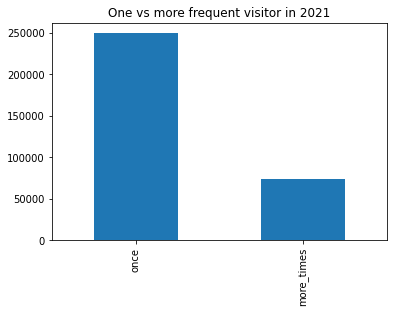

In [37]:
# plot of new vs old visitors in 2021 
print(grouped_df_per_clientID['one_vs_more_times_visitor'].value_counts())
grouped_df_per_clientID['one_vs_more_times_visitor'].value_counts().plot(kind = 'bar')
plt.title('One vs more frequent visitor in 2021')

In [112]:
# plot of number of visits per clientID 
grouped_df_per_clientID.rename(columns={0:'counts'}, inplace = True)

#### Number of client IDs vs number of website visits

1     248594
2      48244
3      13740
4       5992
5       2521
6       1283
7        790
8        487
9        373
10       243
Name: counts, dtype: int64


Text(0.5, 1.0, 'Number of clients vs website visits')

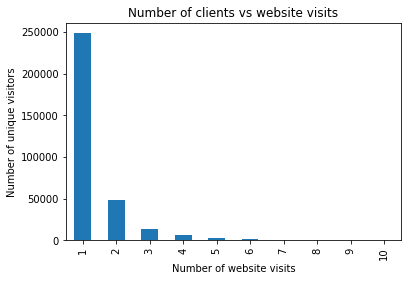

In [125]:
#grouped_df_per_clientID
print(grouped_df_per_clientID[grouped_df_per_clientID['counts'] <= 10]['counts'].value_counts())
grouped_df_per_clientID[grouped_df_per_clientID['counts'] <= 10]['counts'].value_counts().plot(kind = 'bar')
plt.xlabel('Number of website visits')
plt.ylabel('Number of unique visitors')
plt.title('Number of clients vs website visits')

#### Number of clientIDs per channel/source/medium

Text(0.5, 1.0, 'Number of clientIDs per channel group')

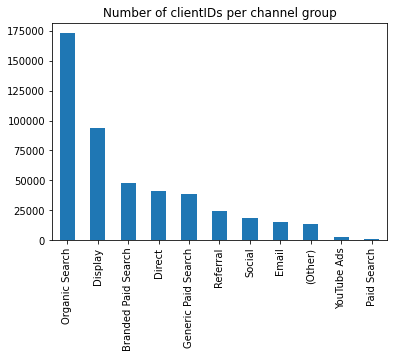

In [73]:
# per channel
df_extended['Channel group'].value_counts().plot(kind = 'bar')
plt.title('Number of clientIDs per channel group')

In [ ]:
# df_extended['User type'].value_counts()
channel_groups = ['Organic Search', 'Display', 'Branded Paid Search', 'Direct', 'Generic Paid Search', 'Referral', 'Social', 'Email', '(Other)', 'YouTube Ads', 'Paid Search']
for channel in channel_groups: 
    print('Results for channel group = ', channel)
    channel_df = df_extended[df_extended['Channel group'] == channel]
    # plot medium and source in 2 subplots
    fig = plt.figure() 
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.subplot(1, 2, 1) # row 1, col 2 index 1
    channel_df['Medium'].value_counts().plot(kind = 'bar')
    plt.xticks(rotation = 90)
    plt.title('Medium levels')
    plt.subplot(1, 2, 2) # index 2
    channel_df['Source'].value_counts().plot(kind = 'bar')
    plt.xticks(rotation = 90)
    plt.title('Source levels')
    # minimize overlap 
    plt.tight_layout()
    plt.show()
# df_extended['Source'].value_counts().plot(kind = 'bar')
# plt.title('Source levels')
df_extended['Medium'].value_counts().plot(kind = 'bar')
plt.title('Medium levels')

#### Evtl. TODO - repeat for other features

#### Number of unique clientIDs per day 

In [38]:
# check single client IDs - extended 
unique_client_ids = df_extended.clientID.value_counts()
print('Total number of rows (client IDs, new or repeated):', len(df_extended))
print('Total number of distinct client IDs:', len(unique_client_ids))
print('Avg number of unique clientIDs per day:', round(len(unique_client_ids)/365, 2))

Total number of rows (client IDs, new or repeated): 470154
Total number of distinct client IDs: 323251
Avg number of unique clientIDs per day: 885.62


Check unique client IDs per day

* Client IDs can be repeated in different days
* The red line indicates the average number of clients per day, calculated as the total number of unique client IDs/365
* As we can see, some peaks seem to exist - January, April, May, November and a big peak in December
    - Some of them probably correspond to specific marketing (email) campaigns - ONGOING
    - The peak in December (i.e. 31. November) corresponds to #GivingTuesday

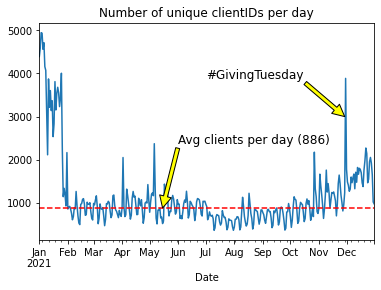

In [49]:
# extract clients per day = sum of unique IDs per day  
# df['Date'].value_counts().plot()
df_extended.groupby('Date')['clientID'].nunique().plot()
plt.axhline(y = round(len(unique_client_ids)/365, 2), color = 'r', linestyle = '--')
plt.title("Number of unique clientIDs per day")
# Annotation of avg number of (unique) number of client IDs per day 
plt.annotate('Avg clients per day (886)',
              xy = ('2021-05-15', round(len(unique_client_ids)/365, 2)), 
              xytext =('2021-06-01', round(len(unique_client_ids)/365, 2) + 1500), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.annotate('#GivingTuesday', 
             xy = ('2021-11-29', 3000), 
             xytext =('2021-07-01', round(len(unique_client_ids)/365, 2) + 3000), 
             color='black',
             # fontweight='bold',
             fontsize = 12,
             arrowprops = dict(facecolor = 'yellow'))
plt.show()

#### Check number of (total) client IDs per day and channel 

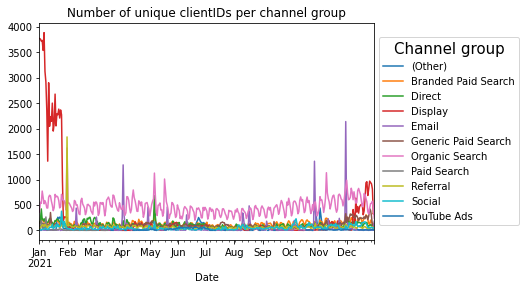

In [46]:
df_grouped_by_channel.unstack()['Users'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of unique clientIDs per channel group')
plt.show()

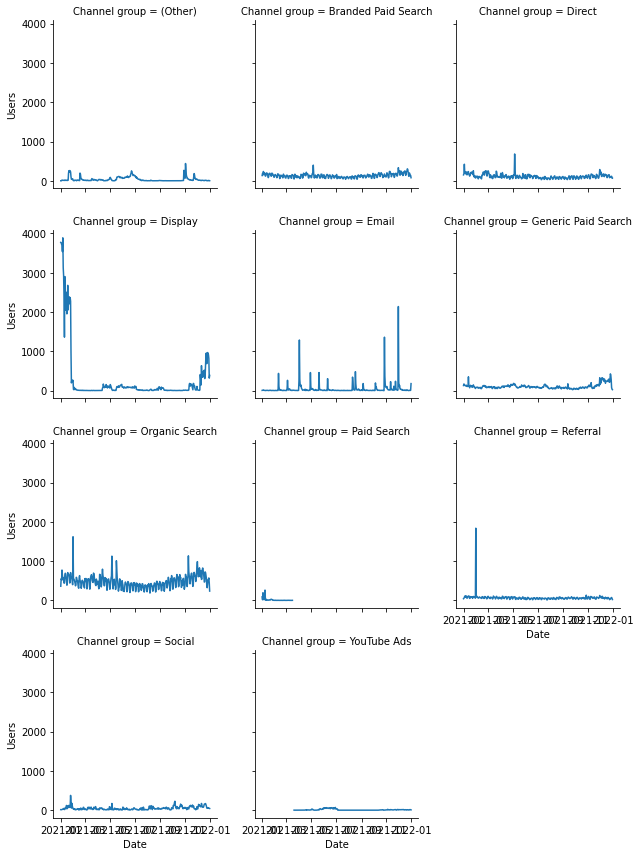

In [48]:
# plot each channel group into a different plot 
import seaborn 

# reset_index() transform grouped table into normal table (with repeated Date)
df_grouped_by_channel2 = df_grouped_by_channel.reset_index()
grid = seaborn.FacetGrid(df_grouped_by_channel2, col = 'Channel group', col_wrap = 3)
grid.map(seaborn.lineplot, 'Date', 'Users')

### Transaction patterns along the year - results with #GivingTuesday

* Same big peak in November (#GivingTuesday) could be observed for daily transactions. The peak is bigger than the one found on daily clientIDs. Also, those transactions seem to mostly come from an email marketing campaign 
    - Those results mask any other daily/seasonal trends 
    - We then decided to repeat analysis with and without #GivingTuesday (i.e. dropping that day from the dataset)
* We can also observe how the peak/s in January on number of clientIDs does not correlate with the number of transactions on that month 

**Evtl. new goal - are results the same on #GivingTuesday as the rest of the year?**

Text(2021-07-01, 1000, '#GivingTuesday')

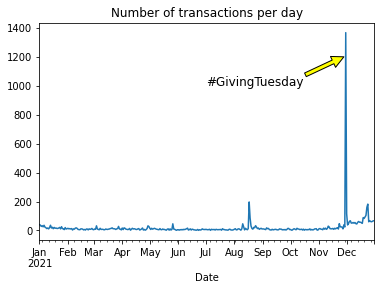

In [64]:
# check transactions per day 
df_extended.groupby('Date')['Transactions'].sum().plot()
plt.title("Number of transactions per day")
# add annotation of #givingtuesday 
plt.annotate('#GivingTuesday',
              xy = ('2021-11-28', 1200), 
              xytext =('2021-07-01',1000), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))

In [65]:
df_transactions = df_extended[df_extended['Transactions'] > 0]
df_transactions_over1 = df_transactions[df_transactions['Transactions'] > 1]
total_number_transactions = df_transactions['Transactions'].sum()
total_number_transactions_over1 = df_transactions_over1['Transactions'].sum() 

print('Total number of transactions: ', total_number_transactions)
print('Avg number of transactions per day:', round(total_number_transactions/365, 2))
print('Total number of clientIDs with transactions:', len(df_transactions.clientID.value_counts()))
print('Total number of clientIDs with more than 1 transaction:', len(df_transactions_over1.clientID.value_counts()))
print('Total conversion rate: ', round(total_number_transactions / len(df_extended)*100), '%')
print('Total value of conversions: ', df_extended['Transaction revenue'].sum(), '€')
print('Average transaction value: ', round(df_extended['Transaction revenue'].sum() / total_number_transactions), '€')
print('Max. transaction value: ', df_extended['Transaction revenue'].max(), '€')
print('Min. transaction value: ', df_extended[df_extended['Transaction revenue'] > 0.0]['Transaction revenue'].min(), '€')

Total number of transactions:  7355
Avg number of transactions per day: 20.15
Total number of clientIDs with transactions: 6486
Total number of clientIDs with more than 1 transaction: 213
Total conversion rate:  2 %
Total value of conversions:  1187983.559 €
Average transaction value:  162 €
Max. transaction value:  63608.5622 €
Min. transaction value:  1.0564 €


Check if transactions come from "new" (i.e. first seen in 2021) or "old" donors

4341    1
3014    1
Name: Transactions, dtype: int64


Text(0.5, 1.0, 'Number of transactions in 2021 for new vs old clients')

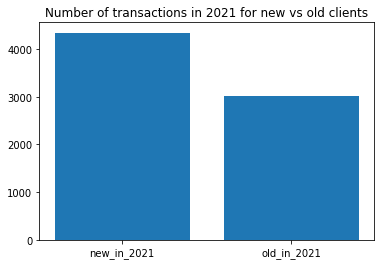

In [58]:
# new/old vs transactions 
df_new_old_client = df_extended.groupby('general_type_of_client')['Transactions'].sum()
print(df_new_old_client.value_counts())
df_new_old_client = df_new_old_client.to_frame(name = 'sum transactions').reset_index()
plt.bar(df_new_old_client['general_type_of_client'], df_new_old_client['sum transactions'])
plt.title('Number of transactions in 2021 for new vs old clients')

5426    1
1929    1
Name: Transactions, dtype: int64


Text(0.5, 1.0, 'Number of transactions in 2021 for new vs old clients')

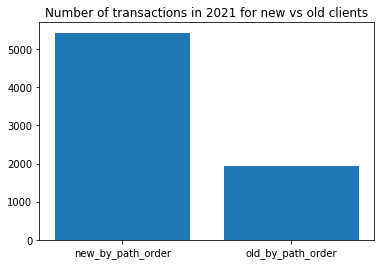

In [60]:
# new/old vs transactions 
df_new_old_client = df_extended.groupby('type_of_client_by_path_order')['Transactions'].sum()
print(df_new_old_client.value_counts())
df_new_old_client = df_new_old_client.to_frame(name = 'sum transactions').reset_index()
plt.bar(df_new_old_client['type_of_client_by_path_order'], df_new_old_client['sum transactions'])
plt.title('Number of transactions in 2021 for new vs old clients')

Compare those results with feature "User type"

In [62]:
df_user_type = df_extended.groupby('User type')['Transactions'].sum()
df_user_type

<class 'pandas.core.series.Series'>
Index: 2 entries, New Visitor to Returning Visitor
Series name: Transactions
Non-Null Count  Dtype
--------------  -----
2 non-null      int64
dtypes: int64(1)
memory usage: 32.0+ bytes


#### Check conversions per channel  

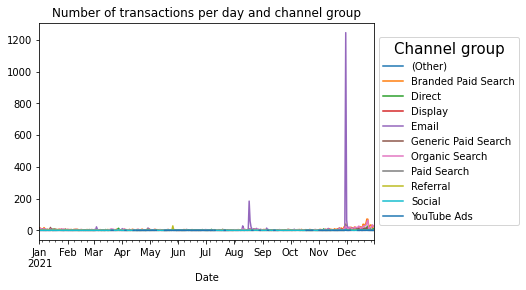

In [66]:
df_grouped_by_channel.unstack()['Transactions'].plot()
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of transactions per day and channel group')
plt.show()

In [68]:
# function to create features of interest 
def grouped_df (df, feats_to_select, feat_to_group_by, feat_to_order_table_by):
    # create features of interest 
    df_grouped = df[feats_to_select].groupby(feat_to_group_by).sum() 
    df_grouped['Transactions per user'] = df_grouped['Transactions'] / df_grouped['Users']
    df_grouped['Revenue per user'] = df_grouped['Transaction revenue'] / df_grouped['Users']
    df_grouped['Users percentage'] = df_grouped['Users'] / df_grouped['Users'].sum()
    df_grouped['Transaction revenue percentage'] = df_grouped['Transaction revenue'] / df_grouped['Transaction revenue'].sum()
    df_grouped['Transaction percentage'] = df_grouped['Transactions'] / df_grouped['Transactions'].sum()
    # reset index - to be able to use grouping feature as feature in plot 
    df_grouped = df_grouped.reset_index() 
    # order table by feature of interest 
    df_grouped = df_grouped.sort_values(feat_to_order_table_by)
    return df_grouped 

In [69]:
feats_to_select = ['Channel group', 'Users', 'Transactions', 'Transaction revenue']
feat_to_group_by = 'Channel group'
feat_to_order_table_by = 'Transactions'
df_grouped_by_channel_general = grouped_df(df_extended, feats_to_select, feat_to_group_by, feat_to_order_table_by)
df_grouped_by_channel_general

,Channel group,Users,Transactions,Transaction revenue,Transactions per user,Revenue per user,Users percentage,Transaction revenue percentage,Transaction percentage
7,Paid Search,1101,1,221.8535,0.000908,0.201502,0.002342,0.000187,0.000136
10,YouTube Ads,2968,2,290.5224,0.000674,0.097885,0.006313,0.000245,0.000272
0,(Other),13282,13,2668.5804,0.000979,0.200917,0.028250,0.002246,0.001768
3,Display,94122,27,3086.4050,0.000287,0.032792,0.200194,0.002598,0.003671
9,Social,18200,42,2781.6205,0.002308,0.152836,0.038711,0.002341,0.005710
8,Referral,24419,151,23318.2807,0.006184,0.954924,0.051938,0.019628,0.020530
2,Direct,41212,774,134516.7638,0.018781,3.264019,0.087656,0.113231,0.105235
5,Generic Paid Search,38336,805,83224.5154,0.020999,2.170923,0.081539,0.070055,0.109449
6,Organic Search,173244,1589,341970.5863,0.009172,1.973925,0.368484,0.287858,0.216044
1,Branded Paid Search,47765,1904,399184.5199,0.039862,8.357260,0.101594,0.336019,0.258872


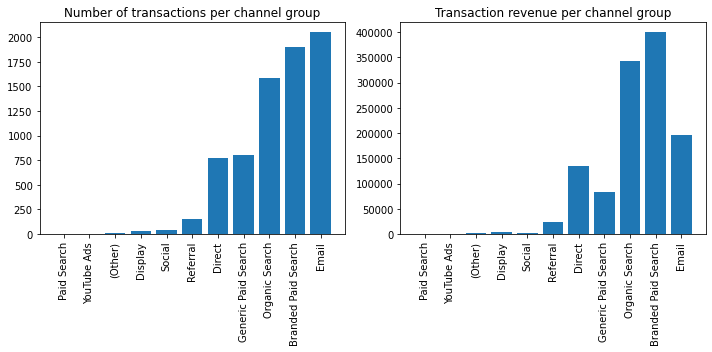

In [70]:
# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1, 2, 1) # row 1, col 2 index 1

plt.bar(df_grouped_by_channel_general['Channel group'], df_grouped_by_channel_general['Transactions'])
plt.xticks(rotation = 90)
plt.title('Number of transactions per channel group')

plt.subplot(1, 2, 2) # index 2
plt.bar(df_grouped_by_channel_general['Channel group'], df_grouped_by_channel_general['Transaction revenue'])
plt.xticks(rotation = 90)
plt.title('Transaction revenue per channel group')

# minimize overlap 
plt.tight_layout()

plt.show()

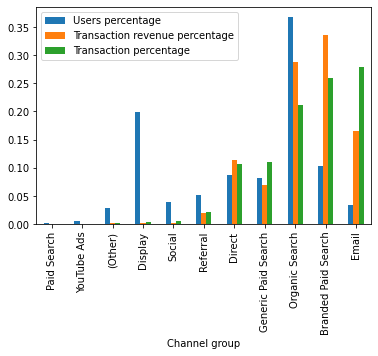

In [ ]:
# df_grouped_by_channel_general.plot(x='Channel group', y=['Transactions per user', 'Revenue per user'], grid=True)
# plotting graph
df_grouped_by_channel_general.plot(x='Channel group', y=['Users percentage', 'Transaction revenue percentage', 'Transaction percentage'], kind="bar")
plt.legend() 
plt.show()

#### Check conversions per channel - Focus December

In [ ]:
#feats_to_select = ['Channel group', 'Users', 'Transactions', 'Transaction revenue']
#feat_to_group_by = 'Channel group'
#feat_to_order_table_by = 'Transactions'
df_december = df_extended[df_extended['Date'] >= '2021-12-01']
df_grouped_by_channel_december = grouped_df(df_december, feats_to_select, feat_to_group_by, feat_to_order_table_by)

Text(0.5, 1.0, 'Number of transactions in 2021 for new vs old clients')

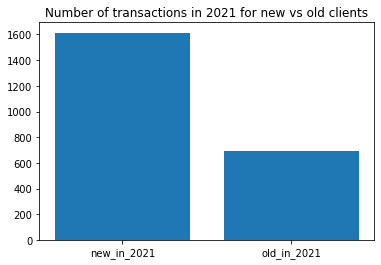

In [ ]:
# new/old vs transactions 
df_december_new_old_client = df_december.groupby('new_old_client')['Transactions'].sum()
df_december_new_old_client = df_december_new_old_client.to_frame(name = 'sum transactions').reset_index()
plt.bar(df_december_new_old_client['new_old_client'], df_december_new_old_client['sum transactions'])
plt.title('Number of transactions in 2021 for new vs old clients')

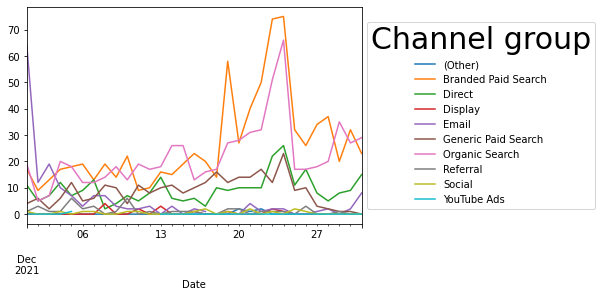

In [ ]:
df_december.groupby(['Date', 'Channel group']).sum().unstack()['Transactions'].plot()
plt.legend(title='Channel group',title_fontsize=30,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

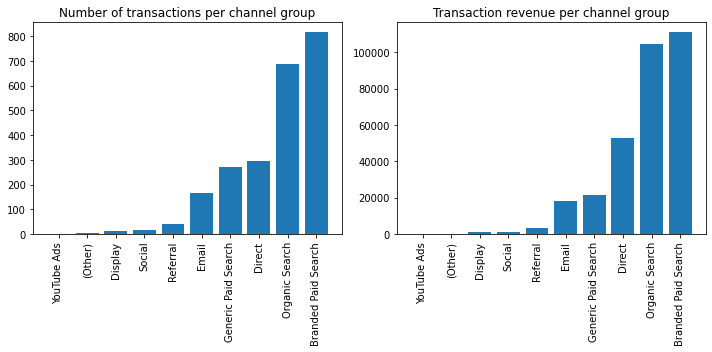

In [ ]:
# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1, 2, 1) # row 1, col 2 index 1

plt.bar(df_grouped_by_channel_december['Channel group'], df_grouped_by_channel_december['Transactions'])
plt.xticks(rotation = 90)
plt.title('Number of transactions per channel group')

plt.subplot(1, 2, 2) # index 2
plt.bar(df_grouped_by_channel_december['Channel group'], df_grouped_by_channel_december['Transaction revenue'])
plt.xticks(rotation = 90)
plt.title('Transaction revenue per channel group')

# minimize overlap 
plt.tight_layout()

plt.show()

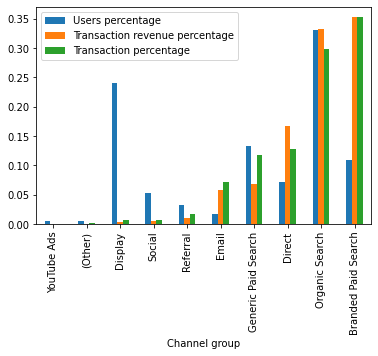

In [ ]:
df_grouped_by_channel_december.plot(x='Channel group', y=['Users percentage', 'Transaction revenue percentage', 'Transaction percentage'], kind="bar")
plt.legend() 
plt.show()

#### Check conversions per channel - Focus #GivingTuesday

In [ ]:
df_giving_tuesday = df_extended[df_extended['Date'] == '2021-11-30']
df_grouped_by_channel_giving_tuesday = grouped_df(df_giving_tuesday, feats_to_select, feat_to_group_by, feat_to_order_table_by)
df_grouped_by_channel_giving_tuesday

,Channel group,Users,Transactions,Transaction revenue,Transactions per user,Revenue per user,Users percentage,Transaction revenue percentage,Transaction percentage
9,YouTube Ads,8,0,0.0000,0.000000,0.000000,0.001778,0.000000,0.000000
0,(Other),43,1,1056.4451,0.023256,24.568491,0.009556,0.008288,0.000691
3,Display,112,2,121.4912,0.017857,1.084743,0.024889,0.000953,0.001382
7,Referral,125,5,316.9336,0.040000,2.535469,0.027778,0.002487,0.003455
8,Social,89,6,137.3380,0.067416,1.543124,0.019778,0.001078,0.004147
5,Generic Paid Search,331,9,422.5782,0.027190,1.276671,0.073556,0.003315,0.006220
6,Organic Search,866,29,2599.9116,0.033487,3.002207,0.192444,0.020398,0.020041
2,Direct,291,39,3444.0117,0.134021,11.835092,0.064667,0.027020,0.026952
1,Branded Paid Search,371,44,5863.2709,0.118598,15.803965,0.082444,0.046001,0.030408
4,Email,2264,1312,113497.4233,0.579505,50.131371,0.503111,0.890459,0.906704


Text(0.5, 1.0, 'Number of transactions in 2021 for new vs old clients')

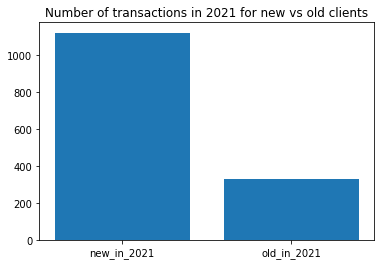

In [ ]:
# new/old vs transactions 
df_giving_tuesday_new_old_client = df_giving_tuesday.groupby('new_old_client')['Transactions'].sum()
df_giving_tuesday_new_old_client = df_giving_tuesday_new_old_client.to_frame(name = 'sum transactions').reset_index()
plt.bar(df_giving_tuesday_new_old_client['new_old_client'], df_giving_tuesday_new_old_client['sum transactions'])
plt.title('Number of transactions in 2021 for new vs old clients')

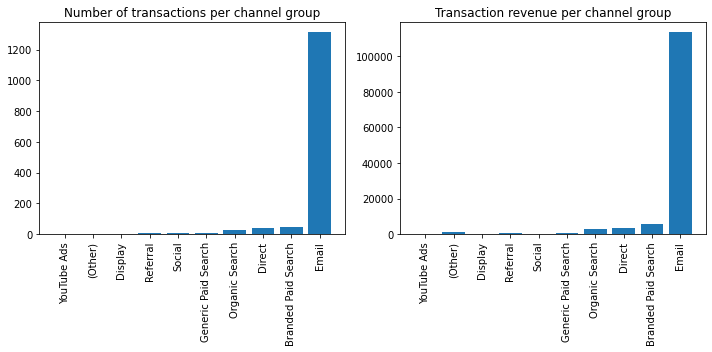

In [ ]:
# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1, 2, 1) # row 1, col 2 index 1

plt.bar(df_grouped_by_channel_giving_tuesday['Channel group'], df_grouped_by_channel_giving_tuesday['Transactions'])
plt.xticks(rotation = 90)
plt.title('Number of transactions per channel group')

plt.subplot(1, 2, 2) # index 2
plt.bar(df_grouped_by_channel_giving_tuesday['Channel group'], df_grouped_by_channel_giving_tuesday['Transaction revenue'])
plt.xticks(rotation = 90)
plt.title('Transaction revenue per channel group')

# minimize overlap 
plt.tight_layout()

plt.show()

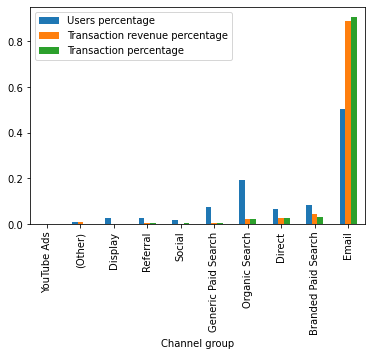

In [ ]:
df_grouped_by_channel_giving_tuesday.plot(x='Channel group', y=['Users percentage', 'Transaction revenue percentage', 'Transaction percentage'], kind="bar")
plt.legend() 
plt.show()

In [ ]:
# new/old vs transactions 
test1 = df_extended.groupby('new_old_client')['Transactions'].sum()
test1 = test1.to_frame(name = 'sum transactions').reset_index()
test1
plt.bar(test1['new_old_client'], test1['sum transactions'])
plt.title('Number of transactions in 2021 for new vs old clients')

,new_old_client,sum transactions
0,new_in_2021,5562
1,old_in_2021,2163


#### Results without #GivingTuesday (2021-11-30)

* Drop #GivingTuesday day - to make analysis easier 
* We still observe 2 peaks in the number of daily transactions
* Even without #GivingTuesday, data peaks seem to correspond to Email marketing. An increase in transactions from Organic Search and Branded Paid Search seems to exist by the end of the year as well


In [ ]:
df_no_giving_tuesday = df_extended
df_no_giving_tuesday = df_no_giving_tuesday[df_no_giving_tuesday['Date'] != '2021-11-30']
df_no_giving_tuesday_with_transactions = df_no_giving_tuesday[df_no_giving_tuesday['Transactions'] > 0]
df_no_giving_tuesday_with_transactions_over1 = df_no_giving_tuesday[df_no_giving_tuesday['Transactions'] > 1]
avg_number_transactions_no_giving_tuesday = df_no_giving_tuesday.Transactions.sum() / 365

In [ ]:
print('Results without Transactions from #GivingTuesday: ')
print('Total number of transactions: ', df_no_giving_tuesday.Transactions.sum())
print('Avg number of transactions per day:', round(df_no_giving_tuesday.Transactions.sum()/365, 2))
print('Total number of clientIDs with transactions:', len(df_no_giving_tuesday_with_transactions.clientID.value_counts()))
print('Total number of clientIDs with more than 1 transaction:', len(df_no_giving_tuesday_with_transactions_over1.clientID.value_counts()))

Results without Transactions from #GivingTuesday: 
Total number of transactions:  6278
Avg number of transactions per day: 17.2
Total number of clientIDs with transactions: 5370
Total number of clientIDs with more than 1 transaction: 226


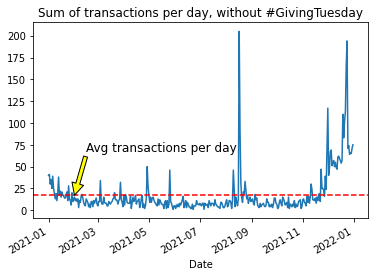

In [ ]:
# check transactions per day - already grouped by date  
df_no_giving_tuesday_grouped = df_no_giving_tuesday.groupby(['Date'])['Transactions'].sum()
df_no_giving_tuesday_grouped.plot()
plt.axhline(y = avg_number_transactions_no_giving_tuesday, color = 'r', linestyle = '--')
plt.title("Sum of transactions per day, without #GivingTuesday")
# Annotation
plt.annotate('Avg transactions per day',
              xy = ('2021-02-01', avg_number_transactions_no_giving_tuesday), 
              xytext =('2021-02-15', avg_number_transactions_no_giving_tuesday + 50), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.show()

In [ ]:
df_channel_no_giving_tuesday = df_no_giving_tuesday[['Date', 'Users', 'Channel group', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews', 'Hits', 'Total events']]
df_not_giving_tuesday_grouped_by_channel = df_channel_no_giving_tuesday.groupby(['Date', 'Channel group']).sum()
# df_not_giving_tuesday_grouped_by_channel

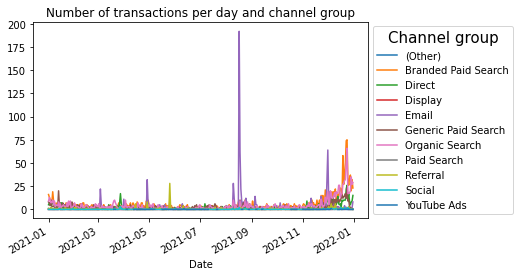

In [ ]:
df_not_giving_tuesday_grouped_by_channel.unstack()['Transactions'].plot()
plt.title('Number of transactions per day and channel group')
plt.legend(title='Channel group',title_fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Channel group	

* Make sure that order remains the same for all plots - to be able to compare them better
* Distribution of channel groups is different in terms of clients ID and transactions, see plots
* Interesting for this MT - check differences in conversions per channel groups

In [ ]:
df_extended['Channel group'].value_counts()
# order by number of transactions - to compare with groups of client IDs 
df_extended = df_extended.sort_values('Transactions')
df_transactions = df_extended[df_extended['Transactions'] > 0]
# set order - depending on number of channel groups, per year and for all data
# reference: client IDs 
order = ['Organic Search', 'Display', 'Branded Paid Search', 'Direct', 'Generic Paid Search', 'Referral', 'Social', 'Email','(Other)', 'YouTube Ads', 'Paid Search']

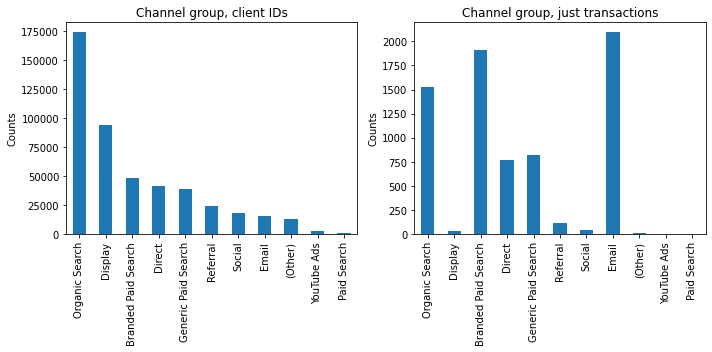

In [ ]:
# change figure size 
fig = plt.figure() 
fig.set_figheight(5)
fig.set_figwidth(10)

# plot of channel group 
plt.subplot(1, 2, 1) # row 1, col 2 index 1

df_extended['Channel group'].value_counts().reindex(order).plot(kind='bar')
# df_extended['Channel group'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Channel group, client IDs')

plt.subplot(1, 2, 2) # index 2
df_transactions['Channel group'].value_counts().reindex(order).plot(kind='bar')
plt.ylabel('Counts')
plt.title('Channel group, just transactions')

# minimize overlap 
plt.tight_layout()

plt.show()

Check percentage of conversions per channel

In [ ]:
tab = pd.crosstab(index=df_extended['Channel group'], columns='perc')
tab/tab.sum() * 100

col_0,perc
Channel group,
(Other),2.816776
Branded Paid Search,10.231543
Direct,8.768652
Display,19.964287
Email,3.327452
Generic Paid Search,8.180145
Organic Search,36.797715
Paid Search,0.233494
Referral,5.189043


In [ ]:
pd.crosstab(index = df_extended['Channel group'], columns = df_extended['Transactions'])

Transactions,0,1,2,3,4,5,6,7,8,16,17,22
Channel group,,,,,,,,,,,,
(Other),13270,11,1,0,0,0,0,0,0,0,0,0
Branded Paid Search,46338,1836,59,8,1,1,0,0,1,1,0,0
Direct,40579,731,28,6,1,0,1,0,1,0,0,0
Display,94111,27,0,0,0,0,0,0,0,0,0,0
Email,13598,2055,31,3,1,1,0,0,0,0,1,0
Generic Paid Search,37751,792,27,2,0,0,0,0,0,0,0,0
Organic Search,171982,1460,53,10,2,2,3,1,0,0,0,0
Paid Search,1100,1,0,0,0,0,0,0,0,0,0,0
Referral,24353,100,9,1,2,1,1,0,0,0,0,1



## TODO - descriptive analysis of transaction yes/no vs other features 

#### Focus: #GivingTuesday (2021-11-30)

In previous plots we have seen that a peak exists in number of (unique) clients IDs, and specially on number of transactions. We therefore would like to check: 

* What is the "normal" ratio of transactions/client IDs, and what is the ratio on #GivingTuesday 

* What is the number of new client IDs (i.e. client IDs that did not appear in the dataset before that day, for the whole 2021)

* Transactions coming from new vs repeated client IDs 

* Proportion of source channels on #GivingTuesday vs rest of year 

# Part II. Attribution Modelling 

First tests 

## Data pre-processing 

* We need to create a table that contains the path (order) for users that have interacted with different channels along the year 2021. 
* As we can observe, some entry errors probably exist - with very big path orders (which probably correspond to the same clientID)
* From the original ~ 350.000 unique clientIDS, 74.759 appear more than once in the dataset. We have to take into account that we are just checking 1 year timeframe - in other words, (potential) donors may have checked the webpage before 01.01.2021. That information should be contained in feature "user type", but Im not sure it I will do something with it

Example based on https://www.kaggle.com/code/hughhuyton/multitouch-attribution-modelling/notebook

In [ ]:
df_model = df_extended[['clientID', 'Date', 'Channel group', 'Operating system', 'Transactions', 'Transaction revenue']] # to work with this one 

In [ ]:
# create path order per clientID 
df_model['path_order'] = df_model.sort_values(['Date']).groupby(['clientID']).cumcount() + 1
df_model.head()


C:\Users\carol\AppData\Local\Temp\ipykernel_2644\3574608967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['path_order'] = df_model.sort_values(['Date']).groupby(['clientID']).cumcount() + 1


,clientID,Date,Channel group,Operating system,Transactions,Transaction revenue,path_order
0,8ec3ed5f-4508-4c5a-bbd9-1b5487ca5133,2021-01-03,Direct,Android,0,0.0,1
313124,1344108479.1621258077,2021-05-17,Organic Search,Android,0,0.0,1
313123,1344086711.1625086569,2021-07-21,Branded Paid Search,Android,0,0.0,2
313122,1344086711.1625086569,2021-06-30,Branded Paid Search,Android,0,0.0,1
313121,1344066949.1638532068,2021-12-03,Organic Search,Windows,0,0.0,1


In [ ]:
new_old_client = df_model[['clientID', 'Date', 'path_order']]
# just keep last one 
new_old_client = new_old_client.drop_duplicates('clientID', keep = 'last')
new_old_client['new_old_client'] = (new_old_client.path_order > 1).astype('int')
new_old_client

,clientID,Date,path_order,new_old_client
0,8ec3ed5f-4508-4c5a-bbd9-1b5487ca5133,2021-01-03,1,0
313124,1344108479.1621258077,2021-05-17,1,0
313122,1344086711.1625086569,2021-06-30,1,0
313121,1344066949.1638532068,2021-12-03,1,0
313120,1344049345.1636546621,2021-11-10,1,0
...,...,...,...,...
3236,14119320.1640512225,2021-12-26,1,0
420310,1812287191.1627127308,2021-12-10,10,1
337533,1448371436.1639391686,2021-12-19,3,1
60095,256128991.1616606930,2021-04-29,10,1


(?) Im not sure what to do with this. Should I get rid of some of the paths? are they entry errors? or they maybe just do not affect the result? 

In [ ]:
# check number of cases of same clientID 
cases_clientID = df_model.groupby(['clientID']).size() 
cases_clientID[cases_clientID > 1]

# transform series into dataframe 
cases_clientID = cases_clientID.to_frame(name = 'counts')

# check frequency table 
pd.crosstab(index=cases_clientID['counts'], columns='count')

col_0,count
counts,
1,248594
2,48244
3,13740
4,5992
5,2521
...,...
216,1
219,1
225,1


In [ ]:
# Aggregate the channels a user interacted with into a single row 
df_paths = df_model.groupby('clientID')['Channel group'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns={"Channel group": "path"})

In [ ]:
# check frequency table 
df_paths.path.value_counts()

[Organic Search]                                                                                                                                                                                          93134
[Display]                                                                                                                                                                                                 48662
[Generic Paid Search]                                                                                                                                                                                     25753
[Direct]                                                                                                                                                                                                  22953
[Branded Paid Search]                                                                                                                                                   

### Heuristic Model I - last touch 

In [ ]:
# create table of last interaction with clientID, transaction and transaction revenue 
df_last_interaction = df_model.drop_duplicates('clientID', keep = 'last')[['clientID', 'Transactions', 'Transaction revenue']]
df_last_interaction.head()

,clientID,Transactions,Transaction revenue
0,8ec3ed5f-4508-4c5a-bbd9-1b5487ca5133,0,0.0
2,883.1608633267,0,0.0
3,1872.1612460548,0,0.0
4,12568.1632331399,0,0.0
6,24938.1636718708,0,0.0


In [80]:
# merge table with dataframe of users path 
df_paths = pd.merge(df_paths, df_last_interaction, how = 'left', on = 'clientID')
df_paths.head()

,clientID,path,Transactions,Transaction revenue
0,1000005671.1568444004,[Display],0,0.0
1,1000006728.1622927843,[Direct],0,0.0
2,1000020259.1556972396,[Referral],0,0.0
3,1000023369.1635190743,[Referral],0,0.0
4,1000024791.1630470945,[Branded Paid Search],0,0.0


In 2020, the date with highest number of transactions of the year is 01.12.2020. As a reminder, that date was 30.11 in 2021. 

**That correspond to #givingTuesday 2020 (01.12) and 2021 (30.11)** 

TODO 
* Figure out if we should get rid of information/transactions on giving Tuesday - or just study the behavior on that specific day vs rest of days 
* Figure out if some other special marketing campaigns exist during the year and try to consider if they may have an effect on the analysis 
* Consider if substituting number of transactions in giving tuesday with value of second peak makes any sense 